Import some essential libraries

In [1]:
# Essentials
import pickle
import os
import math
import numpy as np
import pandas as pd
from torch.utils.tensorboard import SummaryWriter

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

# PyTorch
import torch
import torchvision
import torch.nn as nn  
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch.utils.data import DataLoader

In [2]:
torch.__version__

'1.11.0'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Resources

In [6]:
# Imagenet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),  
        transforms.RandomHorizontalFlip(),  # augmentations
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# 1. Import data, split to train, validation, test set:

In [4]:
# Directories
data_dir = "/storage/intern"
label_path = "./mat/MatLB3"
params_path = "./model/model_params"

In [5]:
# Define parameter
batch_size = 8
num_workers = 2

In [6]:
experiment = "mat"
# Load Data
train_set = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])
train_size = len(train_set)
val_size = len(val_set)

Found 49594 files belonging to 35 classes.


Class name

In [9]:
class_names = train_set.classes
num_class = len(class_names)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
num_batches = math.floor(train_size/batch_size)
print(f"Number of classes: {num_class}")
print(f"Number of batches: {num_batches}")
print(class_names)

35
['GGｻｲｹﾃﾞﾘｯｸｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ', 'GGｼﾞｬｶｰﾄﾞﾃﾞﾆﾑ', 'GGﾅｲﾛﾝ(ECONYL)', 'PVC', 'calf', 'canvas', 'coatedcanvas', 'crocodile', 'denim', 'enamel', 'flora canvas', 'gg crystal', 'gg embossed leather', 'gg imprime ', 'gg nylon', 'gg plus', 'gg supreme canvas', 'ggcanvas', 'guccissima', 'guccissima nylon', 'leather', 'linen', 'microguccissima', 'nylon', 'python', 'quilted leather', 'suede', 'velor', 'velvet', 'wool', 'ｽﾀｰﾌﾟﾘﾝﾄGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ', 'ｽﾈｰｸﾌﾟﾘﾝﾄGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ', 'ﾌｪﾙﾄ', 'ﾏｲｸﾛｸﾞｯﾁｯｼﾏｸﾞﾛｯｼｰﾊﾟﾃﾝﾄﾚｻﾞｰ', 'ﾐﾆGGｽﾌﾟﾘｰﾑｷｬﾝﾊﾞｽ']


In [10]:
# Pickle class_name
f = open(label_path, "wb")
f.write(pickle.dumps(class_names))
f.close()

## Visualize the data

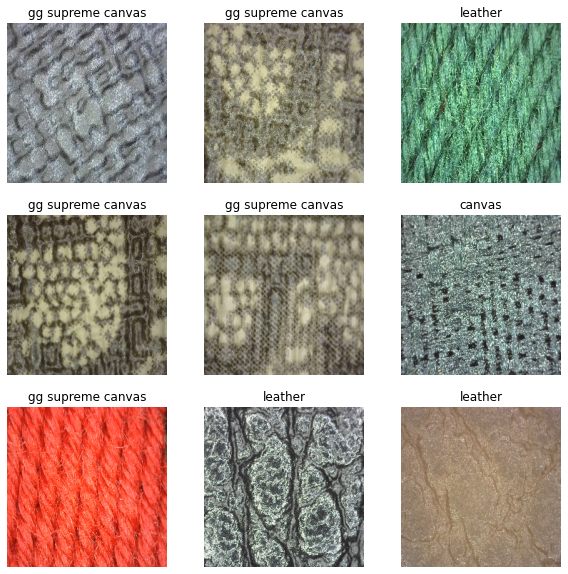

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_loader.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# 2. Compose the model

Create the base model from the pre-trained EfficientNetB4

In [16]:
# Model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
in_fc = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(in_fc, num_class)

### Feature extraction

In [18]:
num_epochs = 1
learning_rate = 0.01

torch.cuda.empty_cache()

# Initialize network
model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
writer = SummaryWriter(f"runs/{experiment}/BatchSize {batch_size} LR {learning_rate}")

# Inspect the model
images, _ = next(iter(train_loader))
writer.add_graph(model, images.to(device))
writer.close()

# Progress bar
outer = tqdm(total=num_epochs, unit="epochs", position=0, desc="Epoch")
inner = tqdm(total=num_batches, unit="batches", position=1, desc="Batch")
batch_log = tqdm(total=0, position=3, bar_format='{desc}')

# Train
epoch_dict = {}
step = 0
for epoch in range(num_epochs):
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)                          # N, C, W, H
        labels = labels.to(device)                          # N

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predictions = outputs.max(1)                     # N
        step_accuracy = (predictions == labels).sum() / inputs.shape[0]
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step += 1
        
        # update dict at end epoch
        if batch_idx == num_batches - 1:
            epoch_dict[epoch] = {"loss": round(loss.item(), 4),
                                 "accuracy": round(step_accuracy.item(), 4)}
            
        # TensorBoard
        writer.add_histogram("Classifier layer parameter", model.classifier.fc.weight)
        writer.add_scalar("Training loss", loss, global_step=step)
        writer.add_scalar("Training Accuracy", step_accuracy, global_step=step)
        
        # update progression bar
        batch_log.set_description_str(f"loss: {round(loss.item(), 4)}, accuracy: {step_accuracy}")
        inner.update(1)
    outer.update(1)

print("Training completed.")
        

In [21]:
# Save model parameters
torch.save(model.state_dict(), params_path)

Predict on test set

Predictions:
 [18 15  5 16 34  5 16 17 16 20  5 16 17 17 20 17  5 16 19 20 20 20 20 20
 16 20 17 20  6 16  5 18]
Labels:
 [17  6  5 16 16  5 16 17 16 20 11 16 17 17 20 17 17 16 19 20  5 20 20 20
 16  5 17 20  6 16  5 20]


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65414 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65420 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 65432 missing from current font.
  font.set_

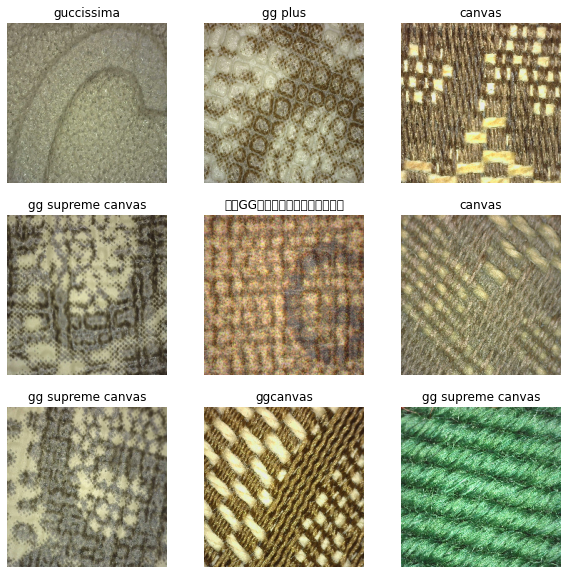

In [28]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_set.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions, axis = 1)
 
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")